# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

<span style="color:purple">**Цель исследования**</span>\
Установить параметры, влияющие на цену объектов жилой недвижимости в Санкт-Петербурге и соседних населённых пунктах.
___________________________________________________

По каждой квартире доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.\
Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Предварительный анализ данных

### Файл с данными и общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    df = pd.read_csv ('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv ('real_estate_data.csv')
# удаляем лишний солбец
del df['Unnamed: 0']
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


In [3]:
# Выводим инфолрмацию о таблице, смотрим тип данных и их полноту.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

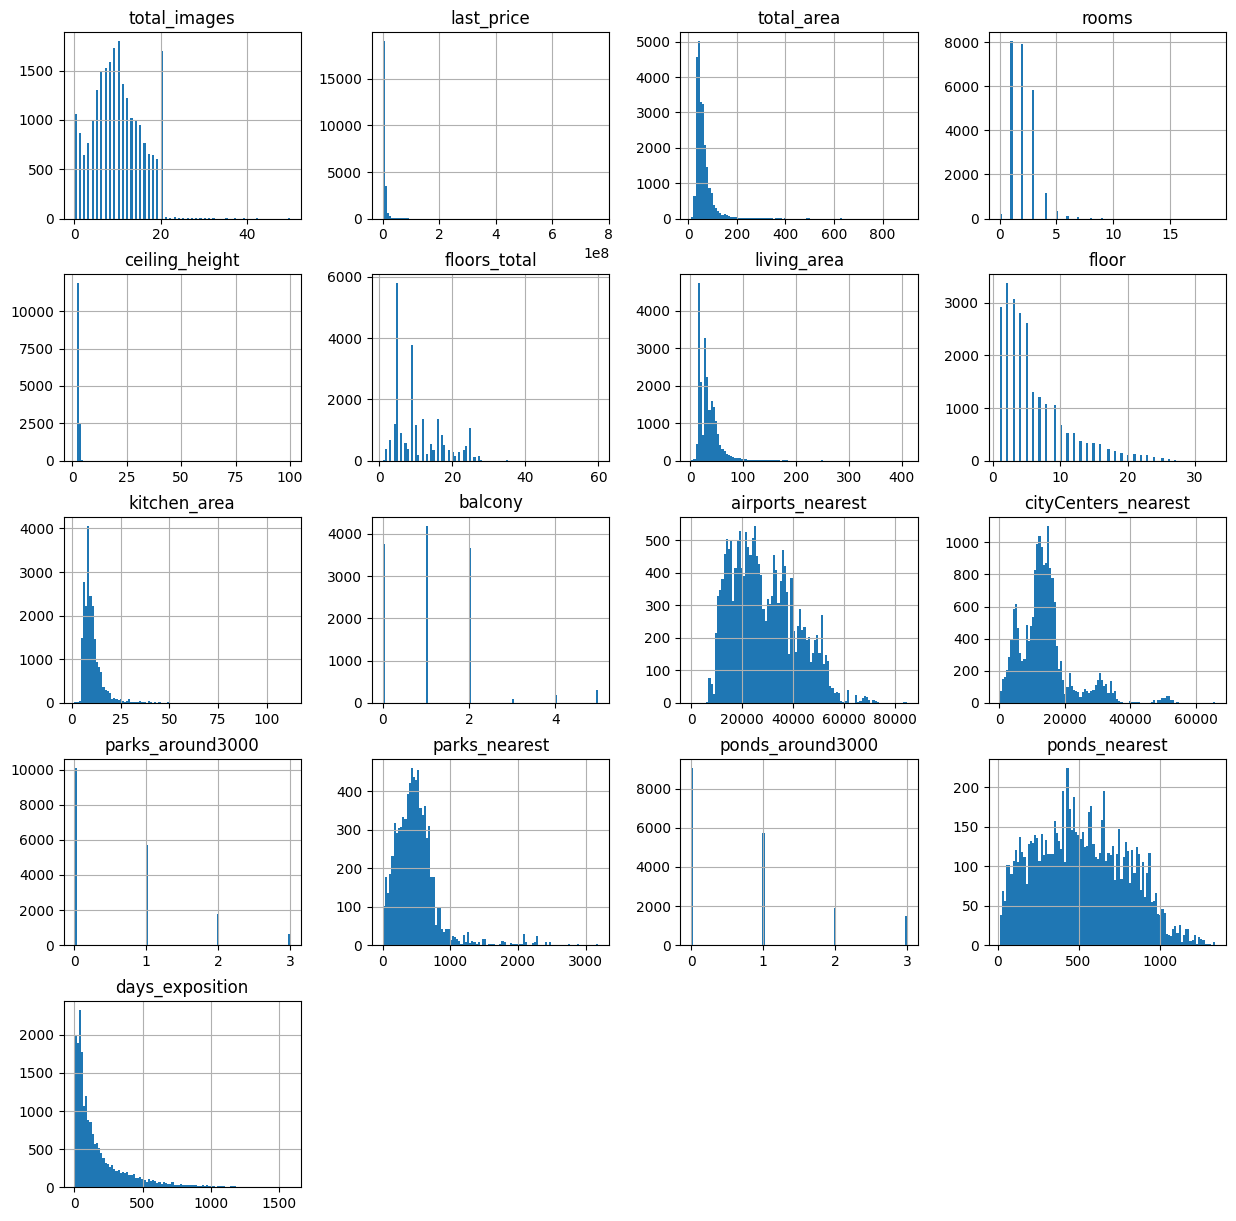

In [4]:
# Строим набор гистограмм для всех числовых столбцов таблицы на одном графике.
df.hist(bins=100,figsize=(15, 15));

### Предварительное изучение содержания датафрейма
Просмотр данных (в т.ч. методами sample, boxplot, а так же с применением фильтрации)\
и исследование первичных гистограммм показало, что <span style="color:green">датасет содержит информацию об объектах, явно относящихся к разным рыночным сегментам.</span>\
\
**Одновременно присутствуют:**
- Городские квартиры среднего  и нижнего ценовых диапазонов.
- Недвижимость большой площади при относительно невысокой стоимости. Педположительно, ето - старые загородные хозяйства.
- Объекты, некоторые из которых с общей площадью более 200 кв м, и стоимостью более 40 млн руб. Вероятно - загородная элитная недвижимость. 
- Жильё площадью до 20 кв м - предположительно части коммунальных квартир.
- И даже объекты странно малой площади, имеющие  0 комнат. Возможно, это - доли в праве собственности.

<span style="color:green">Для лучшей классификации объектов недвижимости по рыночным сегментам необходима консультация специалистов по недвижимости.</span> 

**Разнородность объектов ставит аналитика перед тройственным выбором:**
- Провести анализ "как есть", пожертвовав точность анализа ради сохранения объема данных.\
  И получив так называемую "среднюю температуру по больнице".
- Ввести произвольную категоризацию, оприраясь на своё представление о рынке недвижимости.
- Применить формальный, математический метод  "box plot".\
  Принимая при этом тот факт, что в ряде случаев за пределами  whiskers окажутся не только выбросы данных, но и объекты некоторых относительно немногочисленных категорий недвижимости.
	
**Принято решнние:** \
<span style="color:green">применять метод  "box plot", несмотря на вышеуказанные последствия,</span>\
и только в том случае, когда полученные таким образом рассчёты явно противоречат цели исследования, вносить самостоянельные коррективы.


In [5]:
# Проверим названия столбцов
df.columns.unique()

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Названия написаны корректно, кроме одного 'cityCenters_nearest'. Но оставим его как есть, так как на работу с таблицей это не повлияет.

In [6]:
# Выводим инфолрмацию о  кол-ве пропусков в столбцах 
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Вероятные причины пропусков в столбцах**

Пропуски в метриках 'parks_around3000' и 'ponds_around3000' находятся в одних и тех же строках.\
Они вызваны, скорее всего тем, что эти метрики были введены одновременно (возможно, путём объединения таблиц) и объекты, находящиеся в таблице до этого, не получили значений этих метрик.\
Провека, подтверждающая это, -  ниже. (Количествово строк, удовлетворяющих обеим условиям, равнозначна количеству пропусков в каждой строке отдельно)

In [7]:
# Обнаружено равенство кол-ва попусков в двух столбцах.
# Проверим - пропуски в одних и тех же строках или нет
hypothesis = df[(df['parks_around3000'].isna()) & (df['ponds_around3000'].isna())]['last_price'].count()
hypothesis

5518

Вероятные причины пропусков в других столбцах (в скобках - кол-во пропусков):

- ceiling_height (9195)   -- данные не внесены рекламодателем
- floors_total   (86)     -- данные не внесены рекламодателем
- living_area    (1903)   -- данные не внесены рекламодателем
- kitchen_area   (2278)   -- данные не внесены рекламодателем
- is_apartment   (20924)  -- должен быть параметр bool. В этом случае рекламодатель может оставить поле пустым,  а не ставить "нет"
- balcony       (11519)   -- Нсли балкона нет = рекламодатель может оставить поле пустым,  а не ставить "нет"
- locality_name    (49)   -- данные не внесены рекламодателем
- days_exposition (3181)  -- объекты ещё не проданы или объявление забыли снять

Что касается столбцов 
- airports_nearest      (5542)
- cityCenters_nearest   (5519)
- parks_nearest         (15620)
- ponds_nearest         (14589),

то пропуски в них могут быть вызваны очерёдностью подключения к уже существующей базе данных новых метрик, полученных автоматически на основе картографических данных.

## Предобработка данных

### Обрабатываем колонки с пропусками

- ceiling_height - заменим пропуски медианой
- floors_total - заменяем значением, равным указанному в объявлении этажу. Принимая во внимание, что тем самым несколько увеличится количесиво последних этажей
- living_area  - запрлним значением, рассчитанным через отношение к общей площади
- is_apartment  - заполним False и поменяем формат
- kitchen_area  - запрлним значением, рассчитанным через отношение к жилой площади
- balcony  - заменяем пропуски на 0
- locality_name  - заменяем пропуски на "Нет данных"
- airports_nearest - оставим как есть
- cityCenters_nearest - оставим как есть
- parks_nearest - оставим как есть
- ponds_nearest - оставим как есть
- days_exposition - оставим как есть

Столбцы 
- ponds_around3000  - заменяем на 0
- parks_around3000  - заменяем на 0\
Несмотря на то, что пропуски вызваны, по нашему мнению, техническим фактором (см. выше), предлагается принять условие, что парков или водоёмов ближе 3000 м нет. Так как отсутствие данных в этом параметре воспринимается покупателями, как отсутсяе парка или водоёма, а не данных о них.


In [8]:
# пропуски в 'ceiling_height' Заменяем пропуски медианой
df['ceiling_height']= df['ceiling_height'].fillna(df['ceiling_height'].median())

# На всякий случай проверяем правдоподобность медианы
display (df['ceiling_height'].median())

2.65

In [9]:
# 'is_apartment' - должно быть булево значение. Пропуски меняем на False
# Формат данных в столбце требует изменения. Сделаем это позже.

df['is_apartment']= df['is_apartment'].fillna(False)

# проверяем кол-во пропусков и уникальные значения
print (df['is_apartment'].isna().sum())
print (df['is_apartment'].unique())

0
[False  True]


In [10]:
# В столбцах 'balcony', 'parks_around3000', 'ponds_around3000'
# NaN целесообразно с т.з.цели исследования заменить на 0
df[['balcony', 'parks_around3000', 'ponds_around3000']]= df[['balcony', 'parks_around3000', 'ponds_around3000']].fillna(0)

In [11]:
# 'locality_name' - меняем пропуски на 'Нет данных'
df['locality_name']= df['locality_name'].fillna('Нет Данных')

In [12]:
# 'living_area' - заполняем значением, рассчитанным через отношение к общей площади
k = df['living_area'].median() / df['total_area'].median()
df['living_area'] = (df['living_area'].fillna(df['total_area'] * k)).round(decimals=2)
# выводим на экран коэффициент отношения 'living_area' к 'total_area'
display (k)

0.5769230769230769

In [13]:
# 'kitchen_area' - заполняем значением, рассчитанным через отношение к жилой площади
k = df['kitchen_area'].median() / df['total_area'].median()
df['kitchen_area'] = (df['kitchen_area'].fillna(df['total_area'] * k)).round(decimals=2)
# выводим на экран коэффициент отношения 'kitchen_area' к 'total_area'
display (k)

0.175

In [14]:
# 'floors_total' - заменяем значением, равным указанному в объявлении этажу
df['floors_total'] = df['floors_total'].fillna(df['floor'])
df.sample(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21785,18,4450000.0,36.0,2018-03-26T00:00:00,1,2.65,17.0,16.0,4,False,...,10.00,2.0,Санкт-Петербург,42191.0,10766.0,1.0,134.0,0.0,NaN,131.0
16936,14,4195000.0,42.0,2017-04-23T00:00:00,1,2.65,10.0,18.8,5,False,...,11.00,1.0,Санкт-Петербург,29460.0,13656.0,1.0,399.0,1.0,628.0,190.0
10176,11,4350000.0,31.0,2017-03-15T00:00:00,1,2.65,20.0,17.0,14,False,...,5.42,1.0,Санкт-Петербург,18893.0,4358.0,0.0,NaN,1.0,665.0,207.0


Замены произведены, результат действий проверен 

### Меняем формат данных

В 'irst_day_exposition' меняем формат времени с округлением до дня.\
Мы не знаем в каком часовом поясе время в предоставленных данных, но можно увыдеть, что при наличии даты, часы проигнорированы (установлено 00-00-00). Таким образом, введение поправки на часовой пояс не находит оснований.



В 'is_apartment' меняем формат данных на bool. Так как ответ рекламодателя в поле 'is_apartment' может быть либо "да", либо "нет". В этом параметре рекламодатель может оставить поле пустым,  а не писать неть "нет".

In [15]:
# 'first_day_exposition' меняем формат времени с округлением до дня

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition']).dt.round('1d')
#df.head()

In [16]:
# В 'is_apartment' меняем формат столбца на bool
df['is_apartment'] = df['is_apartment'].astype('bool')
#df.head()

### Обрабатываем дубликаты


Eдинственный столбец, где могут быть скрытые дубликаиы - 'locality_name'\
\
 Решение о заменах:
Поиск глазами в большом списке не даст надёжных результатов. Радикально проблемамодет быть решена, если комментирующие надписи удалить вообще. Маловероятно, что существуют одновременно сло, город и посёлок с одинаковым названием в пределах одного района.

In [17]:
# Выводим на экран и исследуем сами запитси.
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [18]:
# Считаем кол-во уникальных записей - это будет контрольное число
display (df['locality_name'].nunique())

365

In [19]:
# Проводим замену и смотрим результат 
df['locality_name'] = (
    df['locality_name']
    .str.replace('ё', 'е')
    )
#df['locality_name'].nunique()

In [20]:
df['locality_name'] = df['locality_name'].str.replace(r'\b[а-я]\w*\b', '', regex=True)

display (df['locality_name'].nunique())

326

Было 365 уникальных записей, осталось 326. Таким образом устранено 39 скрытых дубликата.

In [21]:
# Проверим, как выглядят очищенные названия
#df['locality_name'].unique()

#Проверялся весь список. Но из-за его размера здесь для примера выведены первые 20
unique_values = df['locality_name'].unique()
print(unique_values[:20])

['Санкт-Петербург' ' Шушары' '  Янино-1' ' Парголово' ' Мурино'
 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин' ' Кудрово' 'Коммунар'
 'Колпино' '   Красный Бор' 'Гатчина' ' Федоровское' 'Выборг' 'Кронштадт'
 'Кировск' ' Новое Девяткино' ' Металлострой']


In [22]:
# Проверим, есть ли явные дубликаты после удаления скрытых
duplicated_row = df.duplicated().value_counts()
duplicated_row

False    23699
dtype: int64

Полученное число равно кол-ву записей (см. info выше). Следовательно, несмотря на 39 скрытых дубликатов в столбце 'locality_name', дублирующих строк не обнаружено. Следовательно другие данные в строках уникальны. В любом случае, устранение дубликатов в названиях позволит проводить корректную группировку, когда это понадобится.

In [23]:
# Проверяем результаты
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


In [24]:
# Проверяем результаты
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

In [25]:
# Проверяем результаты
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Мы осуществили**:
- Обработку пропусков. При этом пропуски в столбцах, которые заполнялись рекламодателями, были заменены на логические или рассчётные значения. В результате в таких толбцах не осталось пропусков.
- Изменен формат  времени на более удобный для дальнейшего анализа,
- Изменен формат столбца is_apartment на соответствующие характеру данных,
- Устранены скрытые дубликаты названий населённых пунктов.

### Добавляем в таблицу новые столбцы

Добавляем в таблицу новые столбцы со следующими параметрами\

- цена одного квадратного метра, затем округляем до двух знаков после запятой;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переводим из метров в км и округляем до ближайших целых значений).

In [26]:
# цена одного квадратного метра с округлением
df['price_meter'] = (df['last_price']/df['total_area']).round(decimals=2)

# день недели публикации объявления
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday

# месяц публикации объявления
df['month_exposition'] = df['first_day_exposition'].dt.month

# год публикации объявления
df['year_exposition'] = df['first_day_exposition'].dt.year

# тип этажа квартиры (значения — «первый», «последний», «другой»)
for fl in range(len(df)):
    if df.loc[fl, 'floor'] == 1:
        df.loc[fl, 'floor_type'] = 'первый'
    elif df.loc[fl, 'floor'] == df.loc[fl, 'floors_total']:
        df.loc[fl, 'floor_type'] = 'последний'
    else:
        df.loc[fl, 'floor_type'] = 'другой'

 # проверяем ввод типа этажа
df['floor_type'].value_counts()       


другой       17363
последний     3419
первый        2917
Name: floor_type, dtype: int64

In [27]:
# расстояние до центра города в километрах с округлением
df['cityCenters_km'] = (df['cityCenters_nearest']/1000).round(decimals=0)

# и проверяем все изменения
df.sample(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
12571,20,4700000.0,68.0,2017-11-13,2,2.76,5.0,37.00,2,False,...,394.0,0.0,NaN,38.0,69117.65,0,11,2017,другой,20.0
4307,5,5300000.0,74.0,2017-04-01,3,2.50,4.0,42.69,4,False,...,NaN,0.0,NaN,624.0,71621.62,5,4,2017,последний,NaN
11232,11,4100000.0,45.5,2017-10-18,2,2.57,9.0,27.00,7,False,...,NaN,1.0,908.0,35.0,90109.89,2,10,2017,другой,11.0


 \
 На этом завершаем модификацию переменной df.\
В дальнейшем без специальной цели будем избегать её перезаписи.\
Для дальнейшей работы создадит новую переменну df_clear 

## Исследовательский анализ данных

Построим отдельные гистограммы для каждого из указанных ниже параметров.
Одновременно определим редкие и выбивающиеся значения.\
В соответствие с принятым для данной работы условиеми (см. п. 1.2  "Предварительное изучение содержания датафрейма")\
**при построении гистограмм удалим такие значения**. 

МЕТОДОЛОГИЧЕСКИЙ ВОПРОС, КОТОРЫЙ НЕОБХОДИМО РЕШИТЬ ПРЕДВАРИТЕЛЬНО
- Каким образом поступить с необычными значениями\
\
При обнаружении некорректных значений можно: 
- а) удалить всю строку с таким значением,
- б) заменить значения на NaN.
> В результате просмотра строк с необычными значениями и оценку их количества (в итоге - их влияние на результаты исследования в целом) было принято решение, в случае невозможности замены на корректные значения, не менять значение на NaN, а удалять такие строки\
\
>***Так как у нас нет возможности получить разъяснения специалистов по недвидимости о сегментах рынка, а также учитывая, что в задачи данной работы не входит анализ каждого сегмена рынка отдельно, решено на этапе очистки данных применять, как стартовый, метод "box plot", и принимать решения отталкиваясь от полученных этим способом цифр, но не принимая их за единственно верные".***

Список столбцов, потенциально подлежащих обработке и дальнеёшему исследованию:
- общая площадь;
-  жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка\
Опишите все ваши наблюдения по параметрам в ячейке с типом markdown.

### 'Общая площадь' и 'Цена продажи'

В соответствие с принятой стратегией очистки данных, удаляем "элитные" объекты - с большой площадью и высокой ценой, обработав их в рамках данного исследования как выбросы.\
При этом мы будем  опираться на математитческие рассчёты методом "box plot".\
Графики boxplot выводить на экран не будем - воспользунмся  только численными данными.


#### **'общая площадь'** и 'цена продажи' до обработки

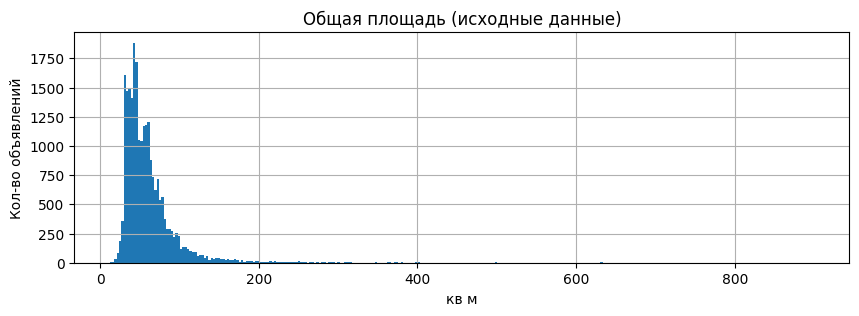

In [28]:
df_clean = df
# общая площадь 'total_area'. Неочищенные данные
df_clean['total_area'].hist(bins=300,figsize=(10, 3))
plt.title('Общая площадь (исходные данные)')
plt.xlabel('кв м')
plt.ylabel('Кол-во объявлений')
plt.show()

In [29]:
# считаем квартили
#df_clean['total_area'].describe(). 
descr_1 = pd.DataFrame(data = df_clean['total_area'].describe())
descr_1

,total_area
count,23699.000000
mean,60.348651
std,35.654083
min,12.000000
25%,40.000000
50%,52.000000
75%,69.900000
max,900.000000


In [30]:
# считаем границы начала зоны выбросов
# автоматизация подсчёта границ "усов" выходит за круг текущего этапа обучения.
# Поэтому я сделал из describe датафрейм и обратиться к нему из формулы. Также поступил и дпльше в аналогичном случае.

elit_area_H = descr_1.loc['75%','total_area']+((descr_1.loc['75%','total_area']-descr_1.loc['25%','total_area'])*1.5)
display (elit_area_H)

114.75000000000001

**'Цена продажи'**

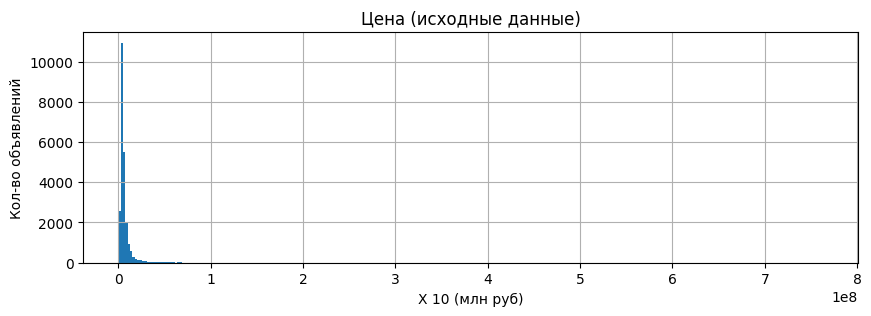

In [31]:
# цена объекта 'last_price'. Неочищенные данные
df_clean['last_price'].hist(bins=300,figsize=(10, 3))
plt.title('Цена (исходные данные)')
plt.xlabel('Х 10 (млн руб)')
plt.ylabel('Кол-во объявлений')
plt.show()

In [32]:
# считаем квартили
#df_clean['last_price'].describe()
descr_2 = pd.DataFrame(data = df_clean['last_price'].describe())
descr_2

,last_price
count,2.369900e+04
mean,6.541549e+06
std,1.088701e+07
min,1.219000e+04
25%,3.400000e+06
50%,4.650000e+06
75%,6.800000e+06
max,7.630000e+08


In [33]:
# считаем верхнюю границу начала зоны выбросов
elit_price_H = descr_2.loc['75%','last_price']+((descr_2.loc['75%','last_price']-descr_2.loc['25%','last_price'])*1.5)
elit_price_H

11900000.0

Математический рассчёт даёт нам границы ныбросов в 114,75 кв метров и 11,9 млн руб.\
Эти границы, тем не менее представляются заниженными - отнеся к выбросам объекты ч ценой выше 12 млн руб мы ограничиваем себя исключительно нижним ценовым диапазоном. Поэтому решено увеличить эти границы до 200 кв метров и 30 млн руб.

Определив границы начала зоны выбрсов, мы устраняем из исследования объекты:
- площадбю больше 200 кв.м. Понимая, что при это будут удалена часть объектов загородной недвижимости совершенно не элитного качества.
- недвижимость дороже 30 млн рублей.

In [34]:
# Посмотрим количество строк в срезе
elit = df_clean[(df_clean['total_area']>200) | (df_clean['last_price']>30000000)]
display (elit.shape)

# Делаем маску
mask_1 = (df_clean['total_area'] > 200) | (df_clean['last_price'] > 30000000)

# Удаляем строки, соответствующие условию в маске
df_clean = df_clean.drop(df_clean[mask_1].index).reset_index(drop=True)

# Проверяем, сколько строк осталось после обработки
elit_control = df_clean[(df_clean['total_area']>200) | (df_clean['last_price']>30000000)]
elit_control.shape

(411, 28)

(0, 28)

#### **'Общая площадь'** и 'Цена продажи' очищенные

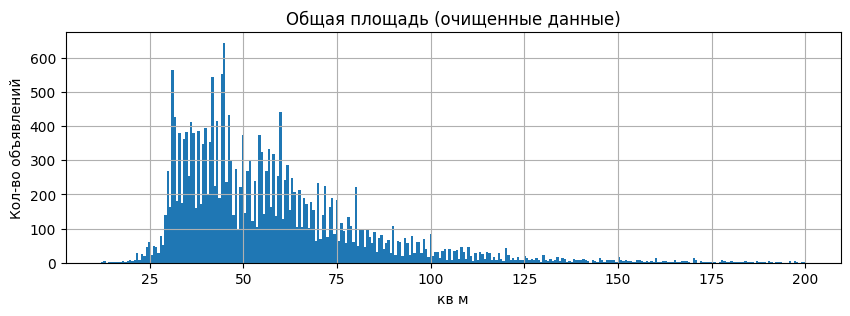

In [35]:
# Строим новый график 'total_area'
df_clean['total_area'].hist(bins=300,figsize=(10, 3))
plt.title('Общая площадь (очищенные данные)')
plt.xlabel('кв м')
plt.ylabel('Кол-во объявлений')
plt.show()

Обнаружены объекты, малой площади. Просмотр строк показал, что у некоторых из них количество комнат 0.
Предположительно - это доли в собственности и/или части коммунальных квартир. (см. выше о необходимости категоризации данных).\
Не будем удаоять их.\
Некоторый провал в районе 50 м - скорее всего отражение специфики набора данных.

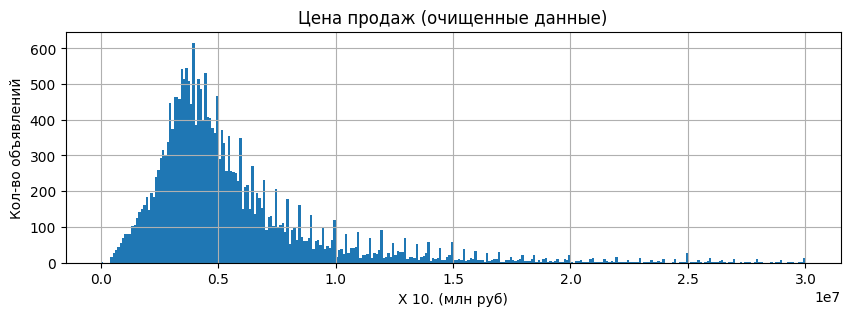

In [36]:
# Строим новый график 'last_price'
df_clean['last_price'].hist(bins=300,figsize=(10, 3))
plt.title('Цена продаж (очищенные данные)')
plt.xlabel('Х 10. (млн руб)')
plt.ylabel('Кол-во объявлений')
plt.show()

Цена выставленных на продажу объектов вполне подчиняется закону нормального распределения случайных величин.\
Пик находится врайоне 4 млн руб, что ожидаемо. Предложения ниже 1 млн руб - предположительно части коммунальных квартир или доли в собственности.

### 'Высота потолков'

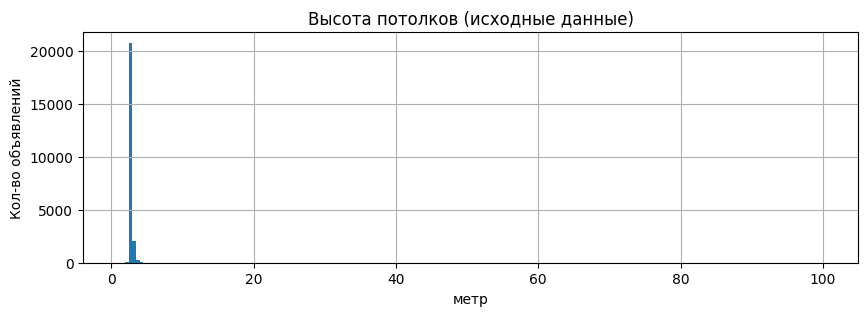

In [37]:
# Неочищенные данные 
df_clean['ceiling_height'].hist(bins=200,figsize=(10, 3))
plt.title('Высота потолков (исходные данные)')
plt.xlabel('метр')
plt.ylabel('Кол-во объявлений')
plt.show()

Обнаружены требующие внимания данные - высокии и слишком низкие потолки

In [38]:
# Сколько строк с высотой потолка больше 6 метров
ceiling_no_norm_l = df_clean[df_clean['ceiling_height']>6]
display (ceiling_no_norm_l.shape)

# Изучаем строки с аномально высокими потолками
#display (ceiling_no_norm_l)

# Устраняем очевидные ошибки - 
# всё, что больше или равно 20 заменил новым значением = потолок, который больше или равен 20 делим на 10.
df_clean.loc[df_clean['ceiling_height'] >= 20, 'ceiling_height'] /= 10

#Сколько строк с высотой потолка больше 6 метров после обработки
ceiling_no_norm_l_2 = df_clean[df_clean['ceiling_height']>6]
ceiling_no_norm_l_2.shape

(29, 28)

(7, 28)

Исправлено 22 записи

In [39]:
#Сколько строк с потолками ниже 2 метров
ceiling_no_norm_s = df_clean[df_clean['ceiling_height']<=2]
ceiling_no_norm_s.shape

(15, 28)

Аномально низких потолков - 15 записей. Так как логичной замены нет - удалим эти строки, а также высокие потолки, которым мы не нашли логичной замены - 7 записей.

In [40]:
#Удаляем строки с аномальными потолками
# Условие для удаления строк пишем в маску
mask_2 = ((df_clean['ceiling_height'] <= 2) | (df_clean['ceiling_height'] > 6))

# Удаляем строки, соответствующих условию в маске
df_clean = df_clean.drop(df_clean[mask_2].index).reset_index(drop=True)

# Проверяем, сколько строк с аномальной высотой потолка после обработки
ceiling_no_norm_l_s = df_clean[(df_clean['ceiling_height'] <= 2) | (df_clean['ceiling_height'] > 6)]
ceiling_no_norm_l_s.shape

(0, 28)

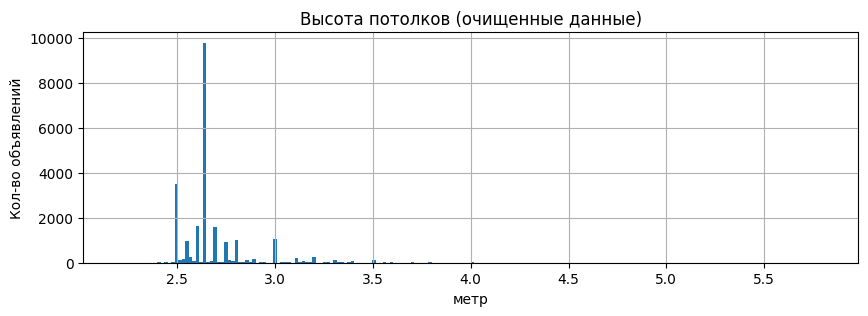

In [41]:
# высота потолков 'ceiling_height' после очистки
df_clean['ceiling_height'].hist(bins=200,figsize=(10, 3))
plt.title('Высота потолков (очищенные данные)')
plt.xlabel('метр')
plt.ylabel('Кол-во объявлений')
plt.show()

Гистограмма о высоте потолков не вызывает вопросов, учитывая ранее введённое ограничение в 6 метров.\
Присутствие в датасете объектов загородной недвижимости делает наличие потолков высотой 6 м вполне вероятным.

### 'Общее количество этажей в доме'

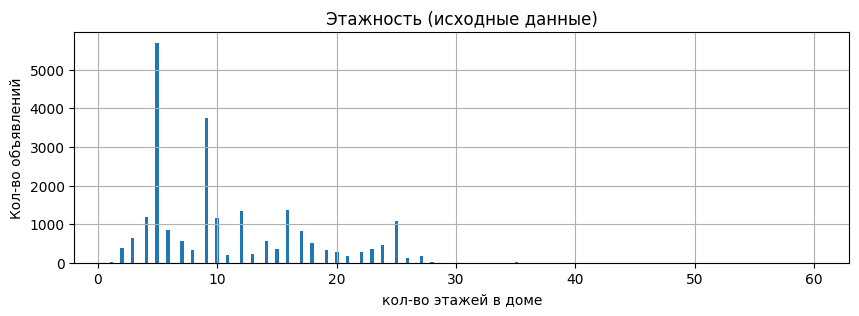

In [42]:
# общее количество этажей в доме 'floors_total'. Не очищенные данныеuj
df_clean['floors_total'].hist(bins=200,figsize=(10, 3))
plt.title('Этажность (исходные данные)')
plt.xlabel('кол-во этажей в доме')
plt.ylabel('Кол-во объявлений')
plt.show()

Здания высотой 60 этажей уже существуют в мире, но по имеющимся у нас данным, в Санкт-Перербурге и окрестностях жилое здание с максимально большим количество этажей - **жилой комплекс «Князь Александр Невский» = 35 этажам.**\
Поэтому удаляем всё, что выше 35 этажей

In [43]:
# Сколько строк со значением больше 32 в 'floors_total'  
floors_total_no_norm_l = df_clean[df_clean['floors_total']>35]
display (floors_total_no_norm_l.shape)

mask_3 = df_clean['floors_total']>35

# Удаляем строки, соответствующих условию в маске
df_clean = df_clean.drop(df_clean[mask_3].index).reset_index(drop=True)

#Сколько строк осталось после обработки
floors_total_no_norm_l = df_clean[df_clean['floors_total']>35]
floors_total_no_norm_l.shape

(5, 28)

(0, 28)

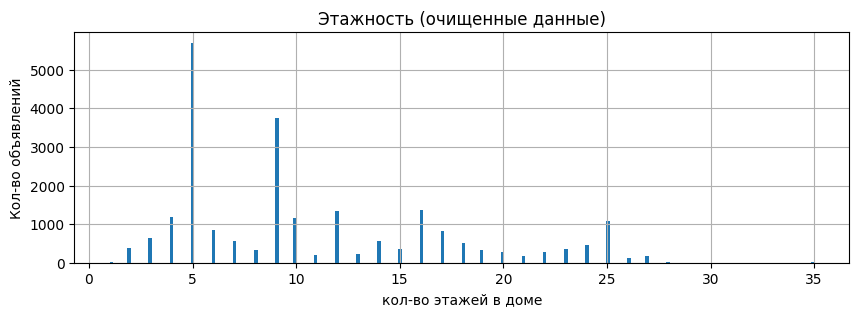

In [44]:
# Очищенные данные 'floors_total'
df_clean['floors_total'].hist(bins=200,figsize=(10, 3))
plt.title('Этажность (очищенные данные)')
plt.xlabel('кол-во этажей в доме')
plt.ylabel('Кол-во объявлений')
plt.show()

Вполне логично, что наиболее массовая этажность - этажность серийной застройки советстких времён - 5, 9, 12 этажей.\
Также заметное количество составляют более поздние - 10, 16 и 25-этажные здания.

### 'Сколько дней было размещено объявление'

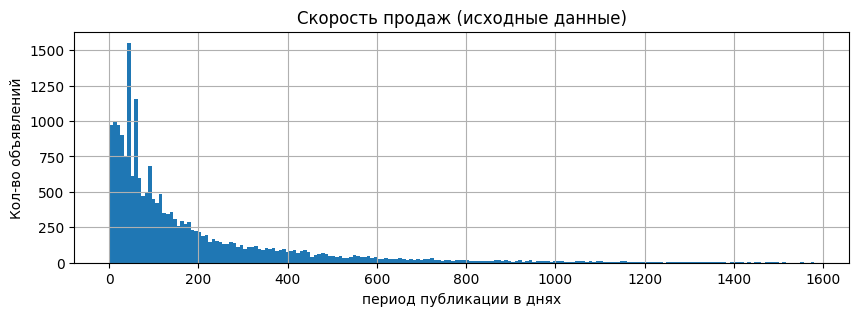

In [45]:
# Гистограмма по столбцу  'days_exposition'
df_clean['days_exposition'].hist(bins=200,figsize=(10, 3))
plt.title('Скорость продаж (исходные данные)')
plt.xlabel('период публикации в днях')
plt.ylabel('Кол-во объявлений')
plt.show()

Срок продаж более двух лет вряд ли говорит о реальных продажах - скорее всего эти объекты не были проданы или объявления не были сняты в разумный срок. Примем срок в 2 года за начало границы зоны выбросов и удалим их

In [46]:
days_exposition_norm_H = 365*2

df_clean = df_clean.drop(df_clean[df_clean['days_exposition']> days_exposition_norm_H].index).reset_index(drop=True)
print('Граница начала выбросов (в днях): ', days_exposition_norm_H)

Граница начала выбросов (в днях):  730


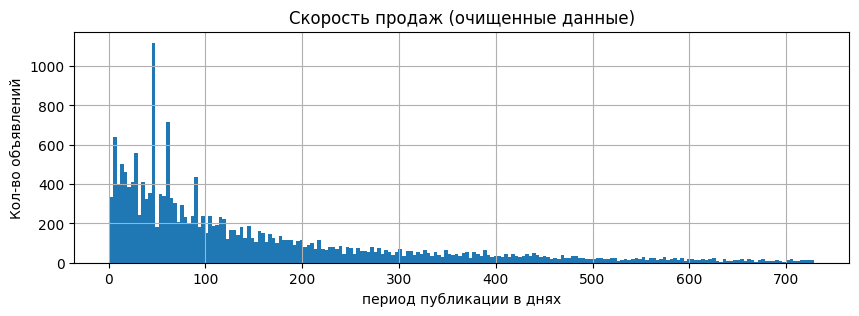

In [47]:
# Гистограмма по столбцу  'days_exposition' после очистки
df_clean['days_exposition'].hist(bins=200,figsize=(10, 3))
plt.title('Скорость продаж (очищенные данные)')
plt.xlabel('период публикации в днях')
plt.ylabel('Кол-во объявлений')
plt.show()

Стоит обратить внимание на объявления, снятые с продажи в очень кототкие сроки.\
Мы не можем точно утверждать, какова причина - реально ли это быстрые продажи высоколиквидных объектов, ошибочно поданные объявления или нереальные объекты, выставленные риелторами с целью проверки спроса.\
\
Для численой оценки количества таких объявлений выведем кол-во тех их них, которые публиковались не больше 1 недели.

In [48]:
days_exposition_week = df_clean[df_clean['days_exposition']<=7]
days_exposition_week.shape

(837, 28)

837 "быстрых" продаж (в течение 1 недели) достаточно большое количество. Маркетологам стоит обратить внимание на это явление.

### Промежуточная проверка датасета (общая) после внесённых изменений

In [49]:
df_clean.shape

(22542, 28)

In [50]:
df_clean.tail(1)
# Проверим результат удаления строк и изменение индексации. Всё в порядке - номер последней строки верен

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
22541,4,1350000.0,32.3,2017-07-21,1,2.5,5.0,12.3,1,False,...,NaN,0.0,NaN,NaN,41795.67,4,7,2017,первый,NaN


В нашем распоряжении осталось значительное число очищенных данных - 22542 строки из первоначальных 23699.\
С 1157 строками (4,9 %) по тем или иным причинам пришлось расстаться.\
Оставшегося количества вполне достаточно для дальнейшего анализа.


### Жилая площадь

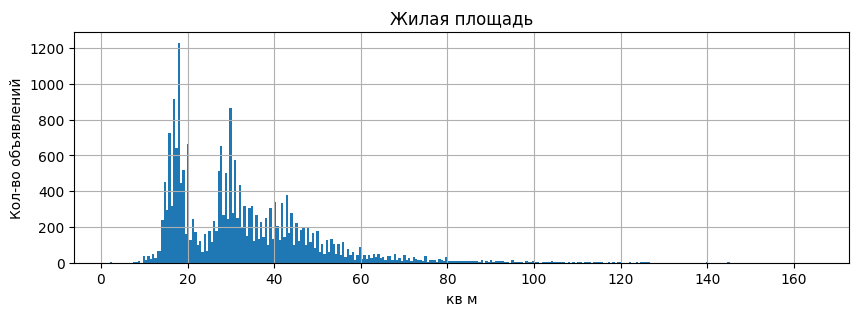

In [51]:
# жилая площадь 'living_area' 
df_clean['living_area'].hist(bins=300,figsize=(10, 3))
plt.title('Жилая площадь')
plt.xlabel('кв м')
plt.ylabel('Кол-во объявлений')
plt.show()

Так как коммуналки решено не удалять, то и маленкую жилую площадь тоже логично оставить.\
Вызывает интерес неравномерность распределения жилой площади в районах 25 и 35 метров. У нас нет оснований полагать, что имеется дефект в качестве данных.\
Скорее всего, это - особенность недвижимости попавшей в выборку.

### Площадь кухни

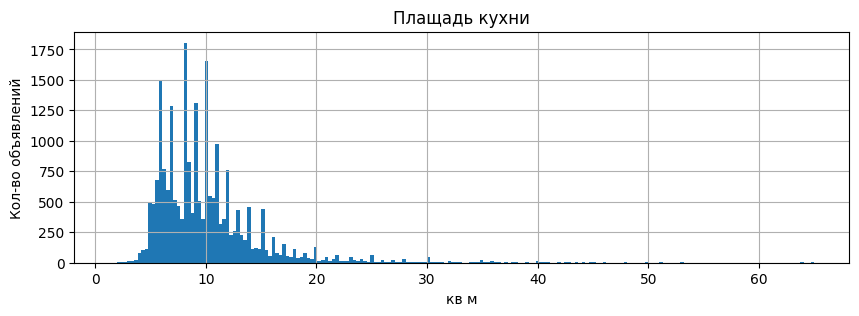

In [52]:
# площадь кухни 'kitchen_area'
df_clean['kitchen_area'].hist(bins=200,figsize=(10, 3))
plt.title('Плащадь кухни')
plt.xlabel('кв м')
plt.ylabel('Кол-во объявлений')
plt.show()

Большие кухни, более 30 метров, требуют проверки.\
Порсмотрим на состав данных в соответствующих строках.

In [53]:
#big_kitchens = df_clean[df_clean['kitchen_area']>30]
#display(big_kitchens.loc[:,'last_price':'parks_nearest'].sample(5))
# Ячкйка закомментирована, так как таблица занимает много места и имеем сугубо служебную роль

Можно увидеть, что:
1. Большие кухни, более 30 метров,  - присутствуют у квартир большой прощади и не вызывают сомнений в правдоподобности,
2. Несколько объектов с непропорционально большой прощадью кухни относительно жилой площади - скорее всего имеют планировку c совмещёнными кухонной зоной и столовой,
3. У некоторых объектов, вероятно, перепутаны жилая площадь и площадь кухни.

Проверим последний вид объектов.

In [54]:
Kitchen_bug = df_clean[df_clean['kitchen_area'] > df_clean['living_area']]
display (Kitchen_bug.shape)
#display (Kitchen_bug.loc[:,'last_price':'parks_nearest'].sample(10))

(329, 28)

Обнаружено 329 объекта, у которых площадь кухни больше жилой площади.\
Но при отсутствии возможности проконсультироваться со специалистом по недвижимости конкретного исследуемого региона, сделать однозначные выводы во многих случаях не представляется возможным.
>Проиллюстрируем примером:
Строка 103. 23 м кухня и 14 м жилая в 24 этажном доме (скорее всего, постройки последних 20 лет) - может быть результатом планировки, при которой кухня выполняет роль столовой или гостинной. При наличии ещё одной отдельной жилой комнаты считать такую планировку студией - не верно, а следовательно, столбец 'studio' не прояснит ситуацию - его заполнение зависит от осведомлённости рекламодателя о нюансах терминологии.

Учитывая вышеизложенное, а также то, что 329 строки - это всего 1.5% от выборки, и **далеко не все из них реально являются ошибочными**, можо принять решение не удалять и не исправлять эти записи - их влияние на результаты расчётов минимально.


### Количество комнат

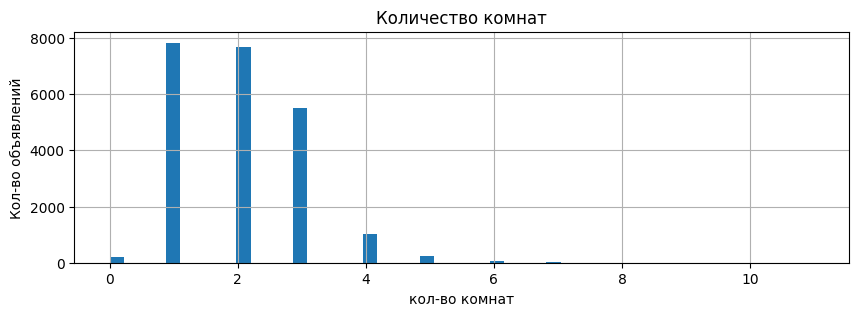

In [55]:
# количество комнат 'rooms'
df_clean['rooms'].hist(bins=50,figsize=(10, 3))
plt.title('Количество комнат')
plt.xlabel('кол-во комнат')
plt.ylabel('Кол-во объявлений')
plt.show()

Значение 0 решено не менять и не отбрасыывать.\
**Вероятно, так определены в датасете продаваемые права на доли в собственности.**

### Тип этажа квартиры

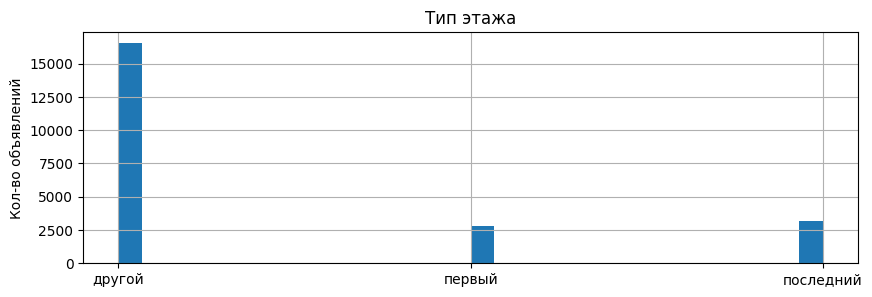

In [56]:
# floor_type - тип этажа квартиры («первый», «последний», «другой») 
df_clean['floor_type'].hist(bins=30,figsize=(10, 3))
plt.title('Тип этажа')
plt.ylabel('Кол-во объявлений')
plt.show()

Отметим, что первых и последних этажей в выборке примерно одинаковое количесиво. Последних немного больше.

### Расстояние до центра города в метрах

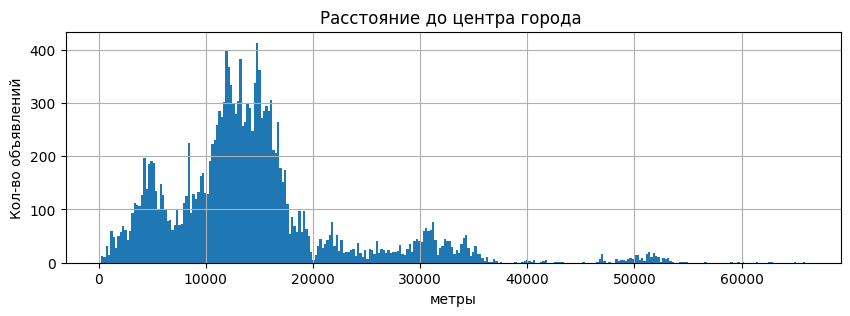

In [57]:
# расстояние до центра города в метрах 'cityCenters_nearest'
df_clean['cityCenters_nearest'].hist(bins=300,figsize=(10, 3))
plt.title('Расстояние до центра города ')
plt.xlabel('метры')
plt.ylabel('Кол-во объявлений')
plt.show()

Большая часть объектов расположена вне центра города. Ворма гистограммы связана, очевидно, с географией застройки.

### Расстояние до ближайшего парка

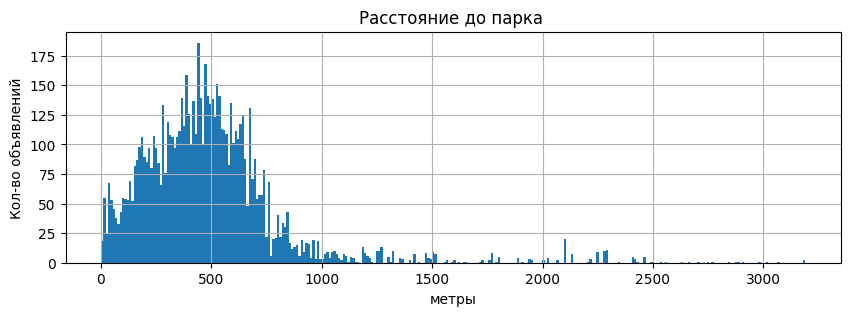

In [58]:
# расстояние до ближайшего парка 'parks_nearest'
df_clean['parks_nearest'].hist(bins=300,figsize=(10, 3))
plt.title('Расстояние до парка ')
plt.xlabel('метры')
plt.ylabel('Кол-во объявлений')
plt.show()

Большая часть объектов имеет парк в пешей доступности.

### Скорость продажи квартиры

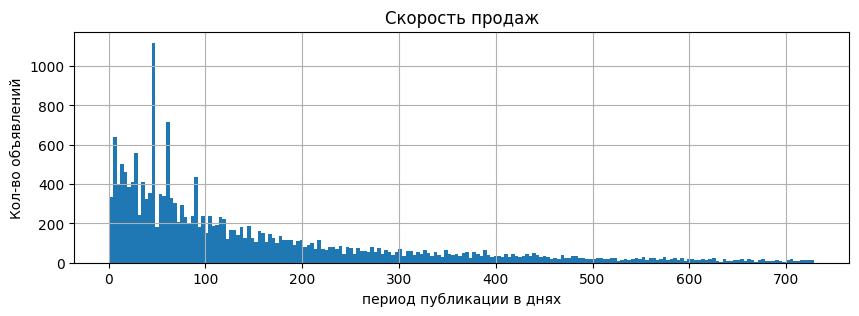

In [59]:
# Гистограмма по столбцу  'days_exposition' после очистки
df_clean['days_exposition'].hist(bins=200,figsize=(10, 3))
plt.title('Скорость продаж')
plt.xlabel('период публикации в днях')
plt.ylabel('Кол-во объявлений')
plt.show()

In [60]:
print('Средняя скорость продаж: ', df_clean['days_exposition'].mean(), ' дней' )
print('Медиана скорости продаж: ', df_clean['days_exposition'].median(), ' дней' )

Средняя скорость продаж:  149.99085538145388  дней
Медиана скорости продаж:  90.00000000000001  дней


In [61]:
# Смотрим распределение очищенных данных скорости продаж  'days_exposition'
df_clean['days_exposition'].describe()

count    19465.000000
mean       149.990855
std        155.478203
min          1.000000
25%         43.000000
50%         90.000000
75%        205.000000
max        729.000000
Name: days_exposition, dtype: float64

**Обычно продажи занимают срок 90 дней (в диапазоне от 43 до 205 дней).**
Можно считать продажи с показателем скорости меньше  43 дней -  быстрыми.\
Продажи, скорость которых больше 205 дней - медленными.


>Маркетологам также стоит обратить внимание на сверхбыстрые продажи (меньше 7 дней) и на три пика в районах 45, 60 и 90 дней.\
\
Эти пики однозначно связаны с регламентом размещения объявлений на портале Яндекс Недвижимость. В эти дни рекламодатели вынуждены либо продлевать свои объявления, либо снимать их.\
Это не означает, что объект продан.\
С большой вероятностью рекламодатель размещает новое, обновленное объявление. Учёт таких снятых объявления как закрытые сделки - искажает картину продаж.  


### Факторы, которые больше всего влияют на общую стоимость объекта

#### Строим матрицу корреляции

In [62]:
# Выбираем только интересующие нас на данном этапе столбцы
df_sciense = df_clean[
    ['last_price','total_area','living_area','kitchen_area','rooms','floor_type','weekday_exposition','month_exposition','year_exposition']]

df_sciense = df_sciense.reset_index(drop=True) 
df_sciense['floor_type'] = df_sciense['floor_type'].replace(['первый','последний','другой'],['1','3','2']).astype('int')

df_correlation = df_sciense.corr()

display ('Коэффициент корреляции цены и ряда факторов:', df_correlation['last_price'].sort_values(ascending=False))

'Коэффициент корреляции цены и ряда факторов:'

last_price            1.000000
total_area            0.786217
living_area           0.679571
kitchen_area          0.615732
rooms                 0.496230
floor_type            0.057685
month_exposition     -0.000492
year_exposition      -0.012412
weekday_exposition   -0.019991
Name: last_price, dtype: float64

Наибольшее влияние на стоимость объектов оказывает их общая палощадь.\
Меньшее, но значимое влияние - размер жилой площади, кухни и количество комнат.

#### Построим  графики зависимости

**Построим графики рассеяния для тех метрик, для которых это уместно**

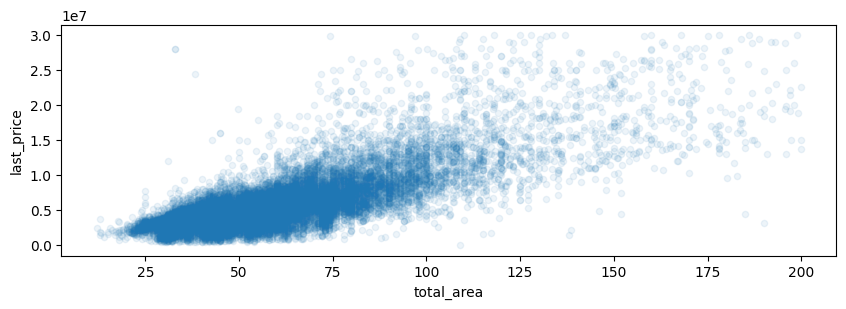

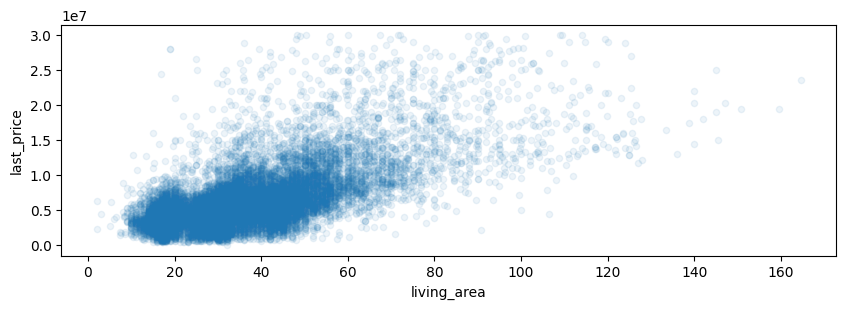

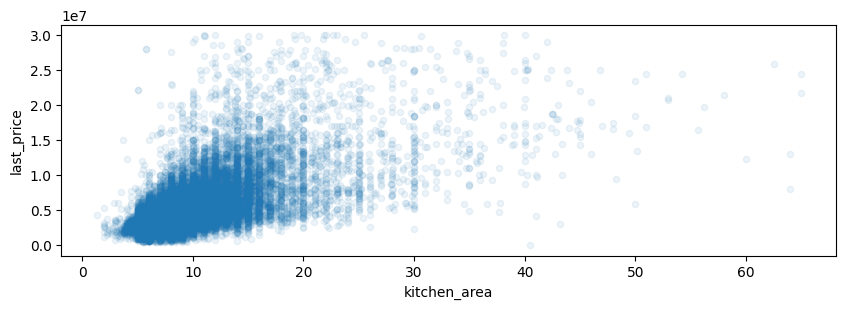

In [63]:
df_sciense.plot(x='total_area', y='last_price', kind='scatter', figsize=(10, 3),alpha=0.08);
df_sciense.plot(x='living_area', y='last_price', kind='scatter', figsize=(10, 3),alpha=0.08);
df_sciense.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(10, 3),alpha=0.08);

На графиках рассеяния четко прослеживается положительная корреляция исследуемых пар.\
Цена продажи растёт одновременно с ростом таких показателей, как **общая площадь, жилая площадь и площадь кухни**.

Наибольшее влияние оказывает общая площадб объекта.

**Для метрик, имеющих дискретность по шкале X построим соответствующие графики**

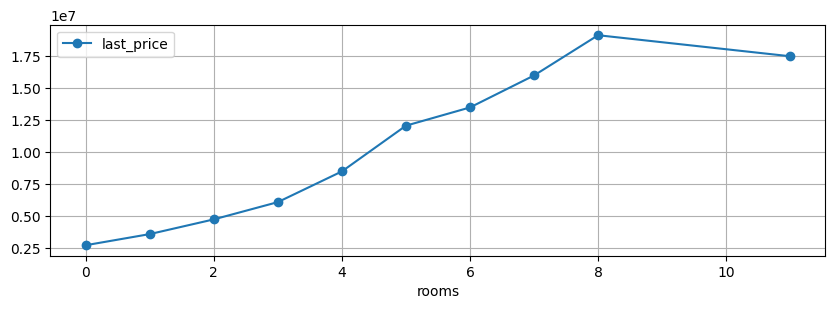

In [64]:
(
 df_sciense.pivot_table(index='rooms', values='last_price', aggfunc='median') 
.plot(style='o-', grid=True, figsize=(10, 3)) 
);

Количество комнот оказывает положительное влячние на цену объекта. Зависимость почти прямая - чем больше комнат, тем дороже объект.

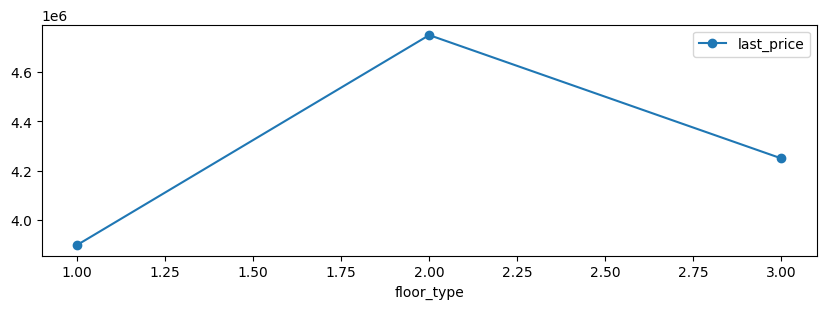

In [65]:
(
 df_sciense.pivot_table(index='floor_type', values='last_price', aggfunc='median') 
.plot(style='o-', grid=False, figsize=(10, 3)) 
);

На графике по шкале  X: 1 - первый этаж, 2 - любой этаж кроме первого и последнего, 3 - последний этаж.\
\
Цена определённо зависит от этажа. Первый и последние этажи продаются по более низкой цене, чем все остальные. При этом квартиры на последних этажах дороже, чем на первых. Коэффициет корреляции в данном случае не является корректным показателем, так как мы имеем дело с метрикой 'floor_type', сотоящей всего из 3-х значений.

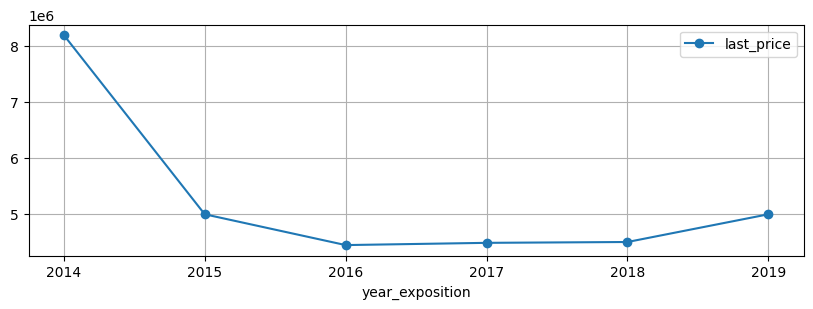

In [66]:
(
 df_sciense.pivot_table(index='year_exposition', values='last_price', aggfunc='median') 
.plot(style='o-', grid=True, figsize=(10, 3)) 
);

Мы видим падение цен в 2015 году и практическое отсутствие заметных изменений в период с 2015 по 2019 год.\
Вывод: год публикаци оказывает влияние на цену, но это влияние общего характера на рынок недвижимости в целом, а не на стоимость отдельного объекта.

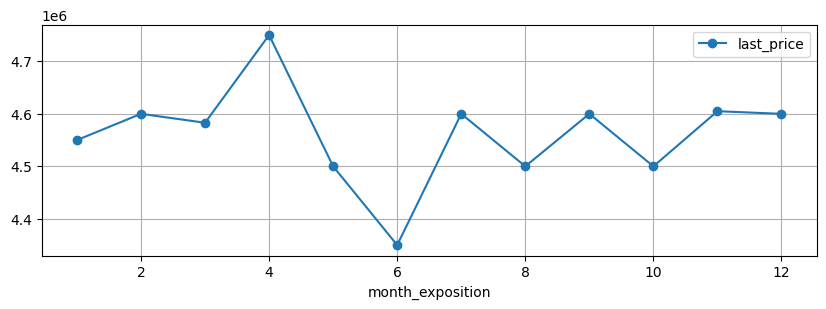

In [67]:
(
 df_sciense.pivot_table(index='month_exposition', values='last_price', aggfunc='median') 
.plot(style='o-', grid=True, figsize=(10, 3)) 
);

Месяц публикации оказывает влияет на цену. Заметно снижение цен в июне. Это вызвано, вероятно, мнижением спроса в летние месяцы, что отражается на ценовом предложении.

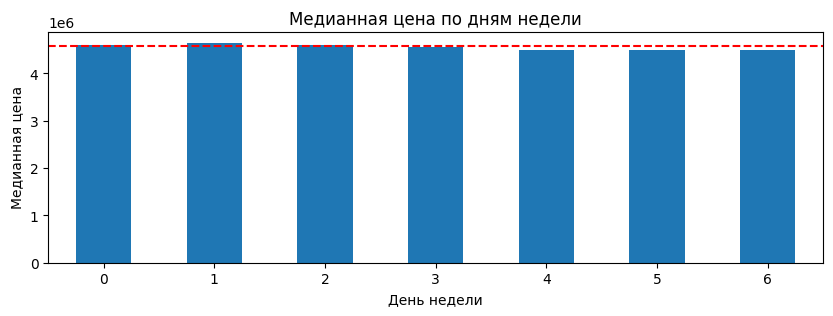

In [68]:
# Медианная цена по дням недели

fig, ax = plt.subplots()

ax = df_clean.groupby('weekday_exposition')['last_price'].median()\
    .plot(kind = 'bar', rot = 0, xlabel = 'День недели', ylabel = 'Медианная цена',
         figsize = (10, 3))
ax.axhline(df_clean['last_price'].median(), color = "red", linestyle = 'dashed'); # Линия общей медианной цены
plt.title('Медианная цена по дням недели')
plt.show()

День недели публикации не влияет на цену.\
Наблюдаемое изменение лежит в очень узких прелделах (50 т.руб). О том же говорит и близкий к нулю коэффициент корреляции 0.014.

### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
    

#### 10 населённых пунктов с наибольшим числом объявлений

In [69]:
name_ann = df_clean.pivot_table(index='locality_name', values='price_meter', aggfunc='count').sort_values(by = 'price_meter', ascending=False)
name_ann.columns = ['ann_count']
name_ann = name_ann.iloc[:10, :]
name_ann

,ann_count
locality_name,
Санкт-Петербург,14822
Мурино,538
Шушары,429
Всеволожск,385
Пушкин,351
Колпино,331
Парголово,319
Гатчина,293
Кудрово,280


#### Средняя цена кв. метра для всех населённых пунктов

In [70]:
name_price_meter_mean = df_clean.pivot_table(index='locality_name', values='price_meter', aggfunc='mean').sort_values(by = 'price_meter', ascending=False).round(decimals=2)
name_price_meter_mean.columns = ['price_meter_mean']
name_price_meter_mean

,price_meter_mean
locality_name,
Зеленогорск,115122.80
Лисий Нос,113728.35
Санкт-Петербург,110495.00
Репино,104238.61
Пушкин,103030.64
...,...
Совхозный,12629.13
Выскатка,12335.48
Вахнова Кара,11688.31


In [71]:
# Присоединяем к 'name_ann_count' таблицу 'name_price_meter_mean'
# Сортируем по столбцу 'price_meter_mean'
name_ann_count = name_ann.merge(name_price_meter_mean, on = 'locality_name', how = 'left').sort_values(by = 'price_meter_mean',  ascending=False)

name_ann_count

,ann_count,price_meter_mean
locality_name,,
Санкт-Петербург,14822,110495.00
Пушкин,351,103030.64
Кудрово,280,92614.78
Парголово,319,90179.11
Мурино,538,85768.31
Шушары,429,78651.55
Колпино,331,75262.86
Гатчина,293,68854.34
Всеволожск,385,68840.35


#### Населённые пункты с самой высокой и низкой стоимостью квадратного метра

In [72]:
# считаем максимум и минимум
name_max_price = name_ann_count['price_meter_mean'].max()
name_min_price = name_ann_count['price_meter_mean'].min()

name_ann_count.query('price_meter_mean == @name_max_price or price_meter_mean == @name_min_price') 

,ann_count,price_meter_mean
locality_name,,
Санкт-Петербург,14822,110495.00
Выборг,227,58346.62


Из 10 городов с наиболее высоким количеством объявлений о продаже максимальная цена квадратного метра в Санкт-Петербурге, ми нимальная в Выборге.

### Зависимость цены объектов в Санкт-Перербурге от расстояния до центра города

In [73]:
df_sciense_spb = df_clean.query('locality_name == "Санкт-Петербург"')

In [74]:
# Строим сводную таблицу
distance_price_spb = df_sciense_spb.pivot_table(index='cityCenters_km', values='last_price', aggfunc='mean').sort_values(by = 'cityCenters_km', ascending=True).round(decimals=0)

distance_price_spb.columns = ['last_price_mean']
# проверяем 
distance_price_spb.T

cityCenters_km,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
last_price_mean,11318667.0,11785669.0,10753988.0,9675135.0,10184146.0,10646210.0,9403343.0,9126556.0,8683090.0,6760742.0,...,5870706.0,5444927.0,5417592.0,4695207.0,3854430.0,4052840.0,3973013.0,8300000.0,5026429.0,4210000.0


<AxesSubplot:xlabel='cityCenters_km'>

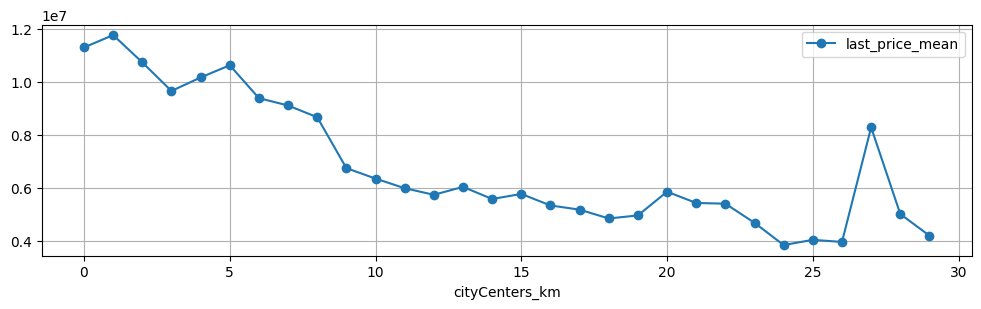

In [75]:
# Строим график
distance_price_spb.plot(style='o-', grid=True, figsize=(12, 3))

In [76]:
# Считаем коэффициент корреляции
df_sciense_spb['cityCenters_km'].corr(df_sciense_spb['last_price'])

-0.4083542063341127

Влияние расстояния до центра города очевидно. Чем ближе к центру, тем недвижимость дороже. Пик на 20 км очевидно вызван наличием пояса жилых районов, а провал на 24-26 - отсутствием жилой застройки.

In [77]:
distance_price_spb_27 = df_sciense_spb.query('cityCenters_km > 25')
distance_price_spb_27

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
242,17,3340000.0,37.00,2018-03-28,1,2.65,5.0,19.00,4,False,...,251.0,1.0,350.0,75.0,90270.27,2,3,2018,другой,26.0
511,13,3250000.0,40.00,2018-06-25,1,2.65,10.0,23.08,1,False,...,159.0,1.0,1250.0,45.0,81250.00,0,6,2018,первый,26.0
704,13,14350000.0,74.00,2017-11-28,2,3.13,5.0,30.00,3,False,...,1496.0,0.0,NaN,128.0,193918.92,1,11,2017,другой,27.0
765,0,7600000.0,111.00,2017-07-26,3,3.00,16.0,63.00,12,False,...,185.0,2.0,72.0,66.0,68468.47,2,7,2017,другой,28.0
1046,0,4072000.0,38.00,2015-10-14,1,2.65,5.0,16.00,4,False,...,NaN,0.0,NaN,285.0,107157.89,2,10,2015,другой,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21780,20,6700000.0,81.00,2018-09-15,3,2.60,5.0,50.00,5,False,...,169.0,1.0,404.0,33.0,82716.05,5,9,2018,последний,26.0
21801,0,5144000.0,64.00,2015-10-14,2,2.65,5.0,33.00,5,False,...,NaN,0.0,NaN,285.0,80375.00,2,10,2015,последний,28.0
22017,17,6300000.0,92.00,2017-07-20,3,2.65,16.0,46.00,7,False,...,36.0,2.0,46.0,14.0,68478.26,3,7,2017,другой,28.0
22222,10,3114406.0,36.13,2018-10-01,1,2.65,5.0,10.00,5,False,...,251.0,1.0,350.0,145.0,86200.00,0,10,2018,последний,26.0


Пик на 27 км вызван наличием всего одного дорогого объекта (строка 691), но с ценой за кв. метр более, чем в 2,5 раза выше, чем у других предложений в на расстоянии 25-29 км от города.

## Общий вывод

 ### Цель  исследования

Определить зависимость рыночной стоимости объектов недвижимости от её характеристик.\
Для этого установить параметры, влияющие на цену объектов.\
Это позволит в дальнейшем построить автоматизированную систему, которая смогла бы отслеживать аномалии и мошенническую деятельность.

### Проблемы базы данных, выявленные в поцессе исследования


Основная проблема, повлиявшая на весь ход исследования и заставлявшая на каждом шаге принимать ограничивающие решения - это тот факт, что датасет содержит информацию об объектах, явно относящихся к разным рыночным сегментам.

Одновременно присутствуют:

- Городские квартиры среднего и нижнего ценовых диапазонов.
- Недвижимость большой площади при относительно невысокой стоимости. Педположительно, ето - старые загородные хозяйства.
- Объекты, некоторые из которых с общей площадью более 200 кв м, и стоимостью более 40 млн руб. Вероятно - загородная элитная недвижимость.
- Жильё площадью до 20 кв м - предположительно части коммунальных квартир.
- И даже объекты странно малой площади, имеющие 0 комнат. Возможно, это - доли в праве собственности.

**Рыночное поведение как продавцов, так и покупателей в разных сегментах часто различается радикально, а следовательно и механизм формарования цен - не одинаков.**

Разнородность объектов ставит аналитика перед выбором:

- Получить так называемую "среднюю температуру по больнице", проведя анализ "как есть".
- Ввести произвольную категоризацию, оприраясь на своё личное представление о рынке недвижимости.

Примененный нами формальный, математический метод "box plot", хотя и корректный сам по себе, оставил за пределами исследования не только выбросы данных, но и объекты некоторых относительно немногочисленных категорий недвижимости.
В частности, практически полностью были удалены так называемые "элитные" объекты как выбросы.

Таким образом, результаты исследования относятся в основном к жилой недвижимости среднего и нижнего ценовых диапазонов и без разделения на городскую и жилую загородную недвижимость. Состояние жилья, которое безусловно тоже влияет на ценообразование, также не может быть учтено, так как даже такого, пусть и условного, параметра, как год постройки в датасете нет. 

### Общие сведения, полученные из исследования

#### Скорость продаж

Обычно продажи жилья занимают срок 79 дней (в диапазоне от 173 до 39 дней).\
Можно считать продажи с показателем скорости меньше 39 дней - быстрыми.
Продажи, скорость которых больше 173 дней - медленными.

Маркетологам также стоит обратить внимание на сверхбыстрые продажи (меньше 7 дней) и на два пика в районах 40 и 60 дней.

Также обнарудено значительное количество объявлений, бывших в публикации по несколько лет.\
Срок продаж в несколько лет вряд ли говорят о реальных продажах - скорее всего эти объекты не были проданы или объявления не были сняты в разумный срок.  

#### 10 населённых пунктов с наиболее активным рынком жилой недвижимости

Наиболее активны рынки жилья (наибольшее количество объявлений о продаже) в населённых пунктах:	
- Санкт-Петербург
- Пушкин
- Кудрово
- Парголово
- Мурино
- Шушары
- Колпино
- Гатчина
- Всеволожск
- Выборг	

При этом максимальная цена квадратного метра - в Санкт-Петербурге, минимальная - в Выборге.


### Параметры, влияющие на цену объектов недвижимости

Изучиина зависимость цены объекта от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год);
- В Санкт-Перербурге - от расстояния до центра города.

Результаты следующие:

#### **Общая площадь**, **Жилая площадь**, **Площадь кухни**


Наибольшее влияние на стоимость объектов оказывает их общая палощадь.
Меньшее, но значимое, влияние - размер жилой площади и кухни.\
Цена продажи растёт одновременно с ростом этих показателей.


**количество комнат**\
Количество комнот оказывает положительное влячние на цену объекта. Зависимость почти идеально прямая - чем больше комнат, тем дороже объект.


**Этаж, на котором расположена квартира (первый, последний, другой)**\
Цена определённо зависит от этажа. Первый и последние этажи продаются по более низкой цене, чем все остальные.\
При этом квартиры на последних этажах дороже, чем на первых.


**Дата размещения (день недели, месяц, год)**\
Год публикаци оказывает влияние на цену, но это влияние общего характера на рынок недвижимости в целом,\
а не на стоимость отдельного объекта.


Есть зависимость от месяца размещения, которая носит сезонный характер. В июне цены предложения ниже других месяцев, что вызвано, скорее всего снижение спроса в летний период.


Не установлено зависимости цены от дня недели размещения объявления.


**Зависимость цены объектов в Санкт-Перербурге от расстояния до центра города**\
Влияние расстояния до центра города ярко выражено. Чем ближе к центру, тем недвижимость дороже.\
Пик на 20 км от города очевидно вызван наличием пояса жилых районов, а провал на 24-26 км - отсутствием там жилой застройки.

### Рекомендации

1. Ввести категоризацию объектов по рыночным сегментам. Выделив при этом, как минимум:
- Загородную недвижимость - хозяйства с земельным участком,
- Загородную недвижимость в котеджных посёлках + котеджи и виллы,
- Доли в праве на недвижимость,
- Части коммунальных квартир.

2. Ввести метрику "Год построёки".


3. Обнаружено 264 объекта, у которых площадь кухни больше жилой площади.\
Это может быть как результатом планировки, при которой кухня выполняет роль столовой или гостинной, так и ошибками при вводе данных.
>При наличии ещё  отдельных жилых комнат, считать такую планировку студией - не верно, а следовательно, столбец 'studio' не прояснит ситуацию - его заполнение зависит от осведомлённости рекламодателя о нюансах терминологии.

Можно рекомендовать внедрение автоматической проверки, которая будет выдавать предупреждение, что соотношение площадей не логично. И только повторное подтверждение позволит опубликовать данные.

4. Маркетологам также стоит обратить внимание на сверхбыстрые продажи (меньше одной недели).\
837 "быстрых" продаж - достаточно большое количество, чтобы обратить внимание на это явление.\
Действительно ли это быстрые продажи высоколиквидных объектов, ошибочно поданные объявления\
или нереальные объекты, выставленные риелторами с целью проверки спроса или с иными целями.


5. Маркетологам также стоит обратить внимание на два пика в районах 45, 60 и 90 дней в скорости продаж.
Эти пики однозначно связаны с регламентом размещения объявлений на портале Яндекс Недвижимость. В эти дни рекламодатели вынуждены либо продлевать свои объявления, либо снимать их.
Это не означает, что объект продан.
С большой вероятностью рекламодатель размещает новое, обновленное объявление. Учёт таких снятых объявления как закрытые сделки - искажает картину продаж.
Рекомендуюм разработать интеллектуальную систему контороля, чтобы минимизировать  появление повторных объявлений и учёта перепубликаций в качестве продаж.


**Чек-лист готовности проекта**

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.